In [24]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from calendar import month_name
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Get dataset
tc_df = pd.read_csv('Comcast_telecom_complaints_data.csv')
tc_df.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No


In [3]:
tc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Ticket #                     2224 non-null   object
 1   Customer Complaint           2224 non-null   object
 2   Date                         2224 non-null   object
 3   Date_month_year              2224 non-null   object
 4   Time                         2224 non-null   object
 5   Received Via                 2224 non-null   object
 6   City                         2224 non-null   object
 7   State                        2224 non-null   object
 8   Zip code                     2224 non-null   int64 
 9   Status                       2224 non-null   object
 10  Filing on Behalf of Someone  2224 non-null   object
dtypes: int64(1), object(10)
memory usage: 191.2+ KB


In [4]:
tc_df.shape

(2224, 11)

In [5]:
# Unique values in Customer Complaint

tc_df['Customer Complaint'].nunique()

1841

In [6]:
# Unique values in Received Via
tc_df['Received Via'].value_counts()

Customer Care Call    1119
Internet              1105
Name: Received Via, dtype: int64

In [7]:
# Unique values in City
tc_df['City'].nunique()

928

In [8]:
# Unique values in State
tc_df['State'].nunique()

43

In [9]:
# Unique values in Status
tc_df['Status'].value_counts()

Solved     973
Closed     734
Open       363
Pending    154
Name: Status, dtype: int64

As open and pending refers to same state and also closed and solved refers to same state. So we can map them to open and closed only.

In [10]:
def setState(x):
    if x == 'Pending':
        return 'Open'
    elif x == 'Solved':
        return 'Closed'
    else:
        return x

In [11]:
tc_df['Status'] = tc_df['Status'].apply(setState)

tc_df['Status'].value_counts()

Closed    1707
Open       517
Name: Status, dtype: int64

In [12]:
# Unique values in Filing on Behalf of Someone
tc_df['Filing on Behalf of Someone'].value_counts()

No     2021
Yes     203
Name: Filing on Behalf of Someone, dtype: int64

To get the trend for number of complaint, we need to sort the dates and get the count for each one.

In [13]:
tc_df['Date_month_year'] = pd.to_datetime(tc_df['Date_month_year'])
tc_df['Month'] =  tc_df['Date_month_year'].apply(lambda x: x.month)
tc_df['Day'] = tc_df['Date_month_year'].apply(lambda x: x.day)
tc_df['Day of Week'] = tc_df['Date_month_year'].apply(lambda x: x.dayofweek)

In [14]:
tc_df.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Month,Day,Day of Week
0,250635,Comcast Cable Internet Speeds,22-04-15,2015-04-22,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No,4,22,2
1,223441,Payment disappear - service got disconnected,04-08-15,2015-08-04,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,8,4,1
2,242732,Speed and Service,18-04-15,2015-04-18,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,4,18,5
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,2015-07-05,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,7,5,6
4,307175,Comcast not working and no service to boot,26-05-15,2015-05-26,1:25:26 PM,Internet,Acworth,Georgia,30101,Closed,No,5,26,1


In [15]:
# Remove duplicate column Date as we already got Date_month_year in same format
tc_df.drop('Date', axis=1, inplace=True)

In [16]:
# Get actual Day name from Day of Week

dayDict = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
tc_df['Day of Week']=tc_df['Day of Week'].map(dayDict)
tc_df.head(5)

,Ticket #,Customer Complaint,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Month,Day,Day of Week
0,250635,Comcast Cable Internet Speeds,2015-04-22,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No,4,22,Wed
1,223441,Payment disappear - service got disconnected,2015-08-04,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,8,4,Tue
2,242732,Speed and Service,2015-04-18,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,4,18,Sat
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,2015-07-05,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,7,5,Sun
4,307175,Comcast not working and no service to boot,2015-05-26,1:25:26 PM,Internet,Acworth,Georgia,30101,Closed,No,5,26,Tue


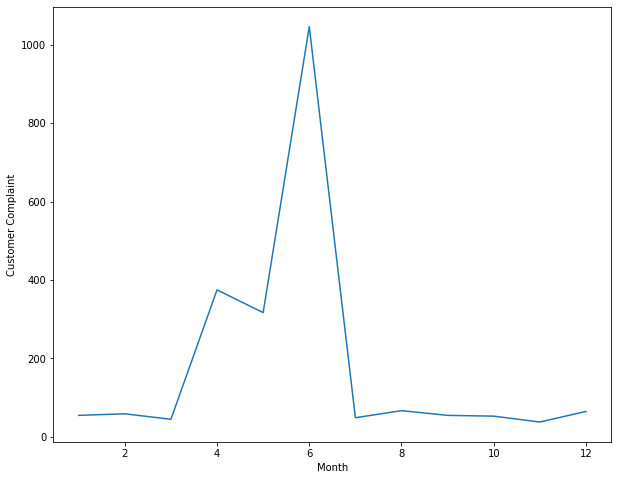

In [17]:
# Get monthly trend of complaints

plt.figure(figsize=(10,8))
monthly_complaint = tc_df.groupby('Month').count().reset_index()
sns.lineplot(x='Month', y= 'Customer Complaint', data = monthly_complaint)
plt.show()

From the monthly trend, we can see, till March, the complaints are low and also after July. But during March to July, the count got a high raise and became maximum in June.

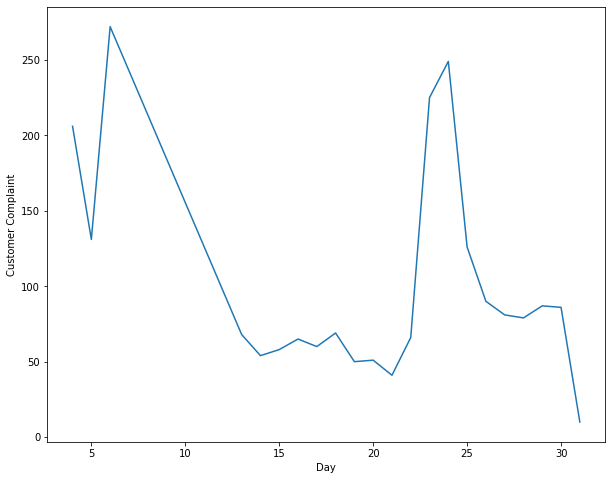

In [18]:
# Get daily trend of complaints

plt.figure(figsize=(10,8))
daily_complaint = tc_df.groupby('Day').count().reset_index()
sns.lineplot(x='Day', y= 'Customer Complaint', data = daily_complaint)
plt.show()

As we can see, the complaint count is very high in the beginning and in end, but it gradually decreases. Also during mid days, it comparativly low.

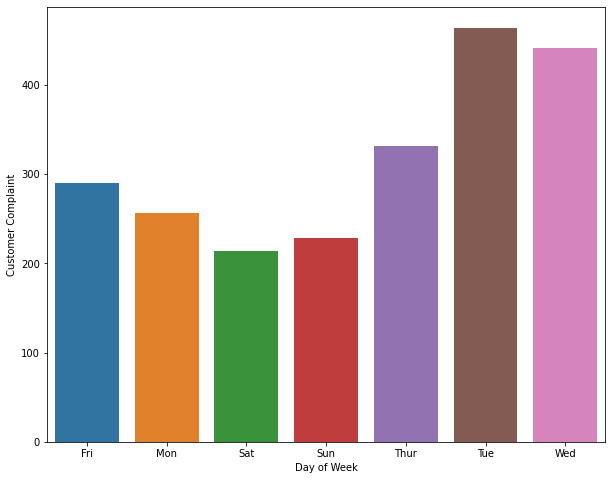

In [20]:
# Get week days trend of complaints

plt.figure(figsize=(10,8))
dw_complaint = tc_df.groupby('Day of Week').count().reset_index()
sns.barplot(x='Day of Week', y= 'Customer Complaint', data = dw_complaint)
plt.show()

We can see, on Tuesday and Wednesday, complaint counts are high as compared to others.

Now we can extract the complaint types from the customer complaint descriptions and analyse.

In [22]:
tc_df['Customer Complaint'] = tc_df['Customer Complaint'].str.title() 
tc_df['Customer Complaint'].value_counts()

Comcast                                                      102
Comcast Data Cap                                              30
Comcast Internet                                              29
Comcast Data Caps                                             21
Comcast Billing                                               18
                                                            ... 
Internet And Service                                           1
Monopolistic Behavior                                          1
Forcing Customer To Pay An Incorrect Bill To Get It Fixed      1
Comcast Data Use Caps                                          1
Assessing Unjustified Late Fees                                1
Name: Customer Complaint, Length: 1740, dtype: int64

In [21]:
all_complaints = tc_df['Customer Complaint'].dropna().tolist()
all_complaints = ' '.join(all_complaints).lower()

We need to remove the commonly used words from the complaints. We can add them in stopwords.

In [23]:
complaint_stopwords = ('Comcast','Now','Company','Day','Someone','Thing','Also', 'to', 'it', 'Got','Way','Call','Called','One','Said','Tell')

In [26]:
STOPWORDS.update(complaint_stopwords)

In [27]:
# Create a word cloud to get frequent words

wordcloud = WordCloud(stopwords=STOPWORDS).generate(all_complaints)

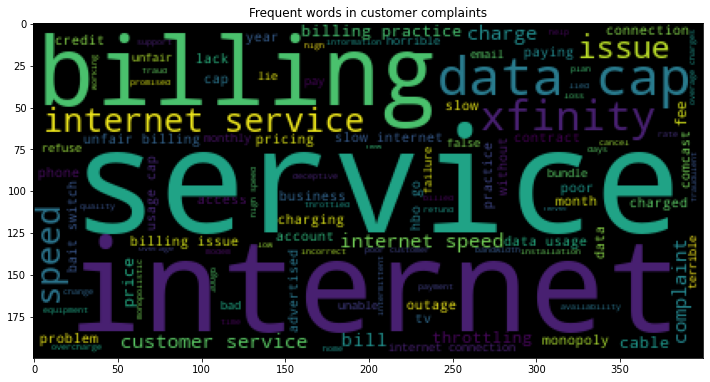

In [28]:
# Plot the word cloud

plt.figure( figsize=(12,10) )
plt.imshow(wordcloud)
plt.title('Frequent words in customer complaints')
plt.show()

So we can see words like billing, service, internet, internet service, customer service, internet speed etc are mostly used in complaint registration.

So we can use them as complaint types and get the frequency as follows.

In [36]:
for k in [k for k in wordcloud.words_.keys()][:3]:
    print('Complaint type: {}, Count: {}'.format(k, wordcloud.words_[k]*100))

Complaint type: service, Count: 100.0
Complaint type: internet, Count: 98.38187702265373
Complaint type: billing, Count: 51.1326860841424


In [37]:
# Get state wise complaint chart

state_status = tc_df.groupby(['State', 'Status']).size().unstack().fillna(0)
state_status.head()

Status,Closed,Open
State,,
Alabama,17.0,9.0
Arizona,14.0,6.0
Arkansas,6.0,0.0
California,159.0,61.0
Colorado,58.0,22.0


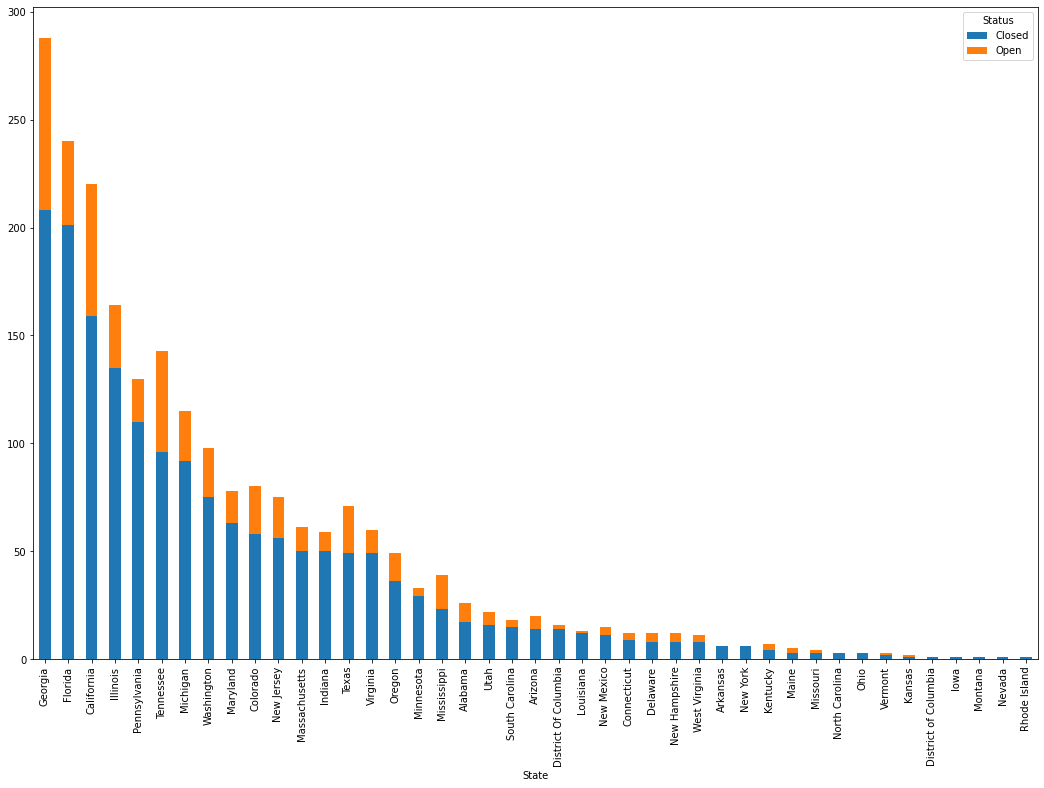

In [39]:
state_status.sort_values(['Closed', 'Open'],axis = 0,ascending=False).plot.bar(figsize=(18,12), stacked=True)
plt.show()

From the plot, we can say, states like Georgia, Florida and California have high number of complaints than others.

We can check the same for Q3 (Jul, Aug, Sept)

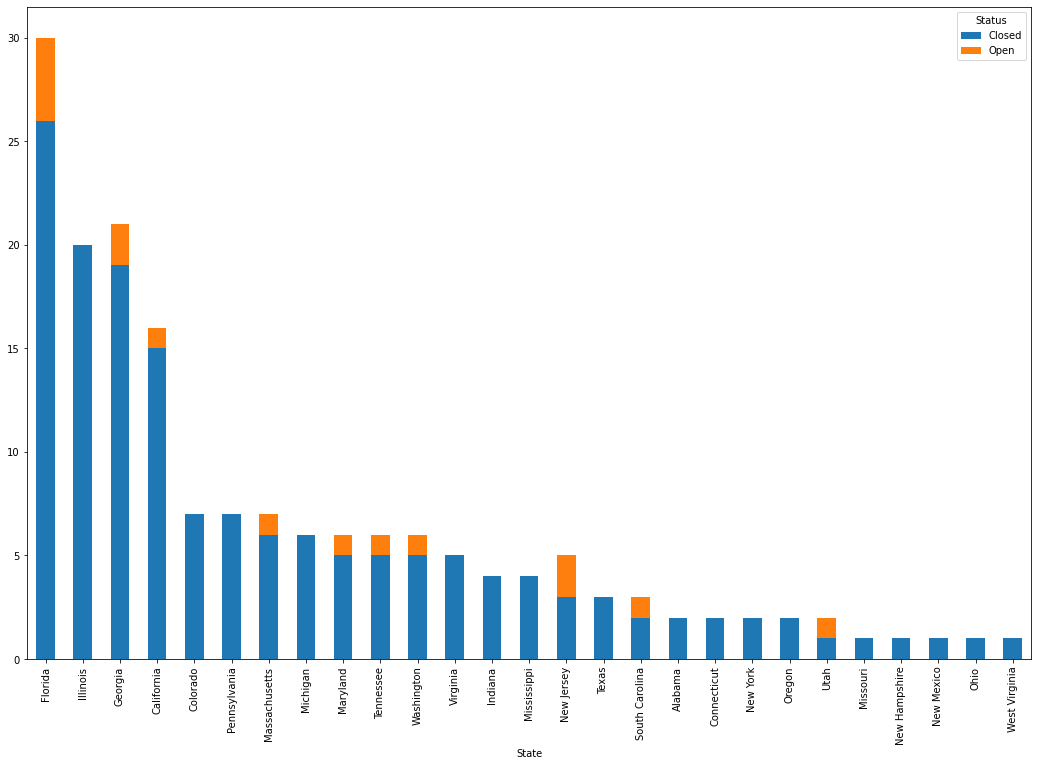

In [55]:
state_status_Q3 = tc_df[(tc_df['Month'] >=7) & (tc_df['Month'] <=9)].groupby(['State', 'Status']).size().unstack().fillna(0)
state_status_Q3.sort_values(['Closed', 'Open'],axis = 0,ascending=False).plot.bar(figsize=(18,12), stacked=True)
plt.show()

In 3rd quater, states like Florida, Llinois and Georgia have high complaint counts than others.

In [54]:
# State with maximum number of cases

tc_df.groupby('State').size().sort_values(ascending=False).to_frame().rename({0: "count"}, axis=1)[:1]

,count
State,
Georgia,288


Georgia has highest number of complaints.

Now we need to get the state having high percentage of unresolved/open cases than others.

In [59]:
state_status['% Open'] = state_status['Open']/state_status['Open'].sum()*100
state_status['% Closed'] = state_status['Closed']/state_status['Closed'].sum()*100
state_status.sort_values('% Open', ascending=False)[:1]

Status,Closed,Open,% Open,% Closed
State,,,,
Georgia,208.0,80.0,15.473888,12.18512


Georgia state has highest percentage of unresolved complaints than others.

In [60]:
# % of resolved cases per Received Via

received_type_status = tc_df.groupby(['Received Via', 'Status']).size().unstack().fillna(0)
received_type_status['% Open'] = received_type_status['Open']/state_status['Open'].sum()*100
received_type_status['% Closed'] = received_type_status['Closed']/state_status['Closed'].sum()*100
received_type_status

Status,Closed,Open,% Open,% Closed
Received Via,,,,
Customer Care Call,864,255,49.323017,50.615114
Internet,843,262,50.676983,49.384886


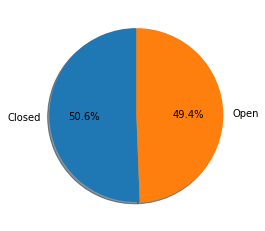

In [65]:
plt.pie(received_type_status['% Closed'], labels = received_type_status, shadow=True, startangle=90, autopct='%1.1f%%')
plt.show()

Resolved cases from internet and customer care call are almost similar.